# <center> AML-3204 Final Project: Collaborative Filtering and Hybrid Recommender Systems </center>

# Team Members:
- Bhavya Vadher (c0894977)
- Viki Patel (c0894966)
- Devarsh Jadhav (c0894965)
- Syed Roman (c0894964)

# Introduction
In this project, we aim to compare the performance of collaborative filtering-based recommender systems with hybrid recommender systems. Collaborative filtering techniques are widely used for recommendation tasks, but combining them with content-based methods can potentially improve performance. We will use the MovieLens dataset and analyze tweets for sentiment analysis to build and evaluate both types of recommenders.


# Data Preparation

In [1]:
import pandas as pd

# Load MovieLens data
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Display datasets
ratings.head()


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [2]:
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
# Load u.genre file to inspect its contents
genre_file = 'u.genre'
with open(genre_file, 'r') as file:
    genres_content = file.readlines()

print(genres_content)

['unknown|0\n', 'Action|1\n', 'Adventure|2\n', 'Animation|3\n', "Children's|4\n", 'Comedy|5\n', 'Crime|6\n', 'Documentary|7\n', 'Drama|8\n', 'Fantasy|9\n', 'Film-Noir|10\n', 'Horror|11\n', 'Musical|12\n', 'Mystery|13\n', 'Romance|14\n', 'Sci-Fi|15\n', 'Thriller|16\n', 'War|17\n', 'Western|18\n', '\n']


In [4]:
# Adjusted code for loading genres
genres = {}
with open(genre_file, 'r') as file:
    for line in file:
        parts = line.strip().split('|')
        if len(parts) == 2 and parts[1].isdigit():
            genre_name, genre_id = parts
            genres[int(genre_id)] = genre_name

print(genres)

{0: 'unknown', 1: 'Action', 2: 'Adventure', 3: 'Animation', 4: "Children's", 5: 'Comedy', 6: 'Crime', 7: 'Documentary', 8: 'Drama', 9: 'Fantasy', 10: 'Film-Noir', 11: 'Horror', 12: 'Musical', 13: 'Mystery', 14: 'Romance', 15: 'Sci-Fi', 16: 'Thriller', 17: 'War', 18: 'Western'}


In [5]:
# Add genres to movies dataframe based on new genre structure
def extract_genres(movie_row):
    genre_vector = movie_row[-19:]  # Last 19 columns are genre flags
    movie_genres = [genre_name for genre_flag, genre_name in zip(genre_vector, genres.values()) if genre_flag == 1]
    return movie_genres

movies['genres'] = movies.apply(extract_genres, axis=1)

# Display datasets
ratings.head(), movies[['movie_id', 'title', 'genres']].head()

(   user_id  item_id  rating  timestamp
 0      196      242       3  881250949
 1      186      302       3  891717742
 2       22      377       1  878887116
 3      244       51       2  880606923
 4      166      346       1  886397596,
    movie_id              title                           genres
 0         1   Toy Story (1995)  [Animation, Children's, Comedy]
 1         2   GoldenEye (1995)    [Action, Adventure, Thriller]
 2         3  Four Rooms (1995)                       [Thriller]
 3         4  Get Shorty (1995)          [Action, Comedy, Drama]
 4         5     Copycat (1995)         [Crime, Drama, Thriller])

In [6]:
import pandas as pd

# Load MovieLens data
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# Load u.genre file with adjusted parsing
genre_file = 'u.genre'
genres = {}
with open(genre_file, 'r') as file:
    for line in file:
        parts = line.strip().split('|')
        if len(parts) == 2 and parts[1].isdigit():
            genre_name, genre_id = parts
            genres[int(genre_id)] = genre_name

# print(genres)

# Add genres to movies dataframe based on new genre structure
def extract_genres(movie_row):
    genre_vector = movie_row[-19:]  # Last 19 columns are genre flags
    movie_genres = [genre_name for genre_flag, genre_name in zip(genre_vector, genres.values()) if genre_flag == 1]
    return movie_genres

movies['genres'] = movies.apply(extract_genres, axis=1)

# Display datasets
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
movies[['movie_id', 'title', 'genres']].head()

,movie_id,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),"[Action, Adventure, Thriller]"
2,3,Four Rooms (1995),[Thriller]
3,4,Get Shorty (1995),"[Action, Comedy, Drama]"
4,5,Copycat (1995),"[Crime, Drama, Thriller]"


In [8]:
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,genres
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,"[Action, Adventure, Thriller]"
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,[Thriller]
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Action, Comedy, Drama]"
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,"[Crime, Drama, Thriller]"


In [9]:
movies.shape

(1682, 25)

## Data Cleaning and Validation

### Check for Missing Values

In [10]:
# Check for missing values in the ratings dataset
print("Missing values in ratings dataset:")
print(ratings.isnull().sum())

# Check for missing values in the movies dataset
print("\nMissing values in movies dataset:")
print(movies.isnull().sum())


Missing values in ratings dataset:
user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

Missing values in movies dataset:
movie_id                 0
title                    0
release_date             1
video_release_date    1682
IMDb_URL                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children                 0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
genres                   0
dtype: int64


- The ratings dataset has no missing values.
- The movies dataset has missing values in the release_date, video_release_date, and IMDb_URL columns.

Let's handle the missing values by dropping the video_release_date column and rows with missing release_date and IMDb_URL.

### Handle Missing Values

In [11]:
# Drop the 'video_release_date' column
movies.drop(columns=['video_release_date'], inplace=True)

# Drop rows with missing 'release_date' and 'IMDb_URL'
movies.dropna(subset=['release_date', 'IMDb_URL'], inplace=True)

# Verify that missing values have been handled
print("Missing values after cleaning:")
print(movies.isnull().sum())


Missing values after cleaning:
movie_id        0
title           0
release_date    0
IMDb_URL        0
unknown         0
Action          0
Adventure       0
Animation       0
Children        0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
genres          0
dtype: int64


### Verify Data Types

In [12]:
# Verify data types in the ratings dataset
print("Data types in ratings dataset:")
print(ratings.dtypes)

# Verify data types in the movies dataset
print("\nData types in movies dataset:")
print(movies.dtypes)


Data types in ratings dataset:
user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object

Data types in movies dataset:
movie_id         int64
title           object
release_date    object
IMDb_URL        object
unknown          int64
Action           int64
Adventure        int64
Animation        int64
Children         int64
Comedy           int64
Crime            int64
Documentary      int64
Drama            int64
Fantasy          int64
Film-Noir        int64
Horror           int64
Musical          int64
Mystery          int64
Romance          int64
Sci-Fi           int64
Thriller         int64
War              int64
Western          int64
genres          object
dtype: object


### Check for Duplicates

In [13]:
# Convert 'genres' column to a tuple for duplicate checking
movies['genres_tuple'] = movies['genres'].apply(tuple)

# Check for duplicates in the ratings dataset
ratings_duplicates = ratings.duplicated().sum()
print(f"Number of duplicate rows in ratings dataset: {ratings_duplicates}")

# Check for duplicates in the movies dataset
movies_duplicates = movies.duplicated(subset=['movie_id', 'title', 'release_date', 'IMDb_URL', 'genres_tuple']).sum()
print(f"Number of duplicate rows in movies dataset: {movies_duplicates}")

# Drop the temporary 'genres_tuple' column after checking
movies.drop(columns=['genres_tuple'], inplace=True)


Number of duplicate rows in ratings dataset: 0
Number of duplicate rows in movies dataset: 0


## Exploratory Data Analysis (EDA)

### Basic Statistics and Distribution of Ratings


            user_id        item_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08


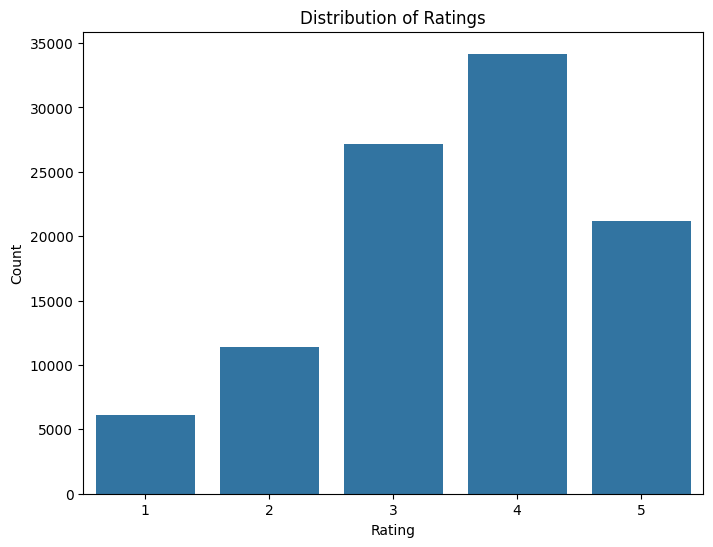

In [14]:
# Basic statistics of the ratings
print(ratings.describe())

# Distribution of ratings
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Number of Ratings per User

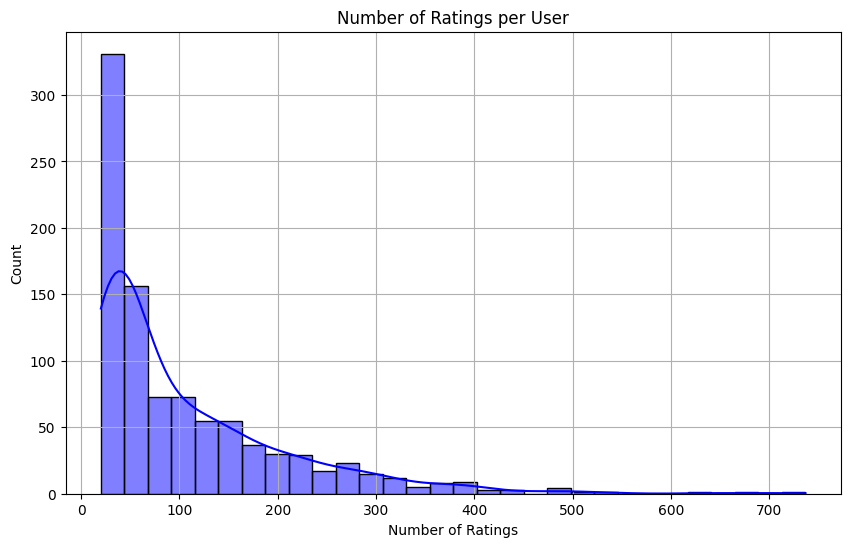

In [15]:
import seaborn as sns

# Number of ratings per user
ratings_per_user = ratings.groupby('user_id').size()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=30, kde=True, color='blue')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.grid(True)
plt.show()

- The majority of users have rated fewer than 100 movies.
- There is a significant drop-off in the number of users as the number of ratings per user increases.
- A few users have rated a large number of movies, indicating the presence of highly active users.

### Number of Ratings per Movie

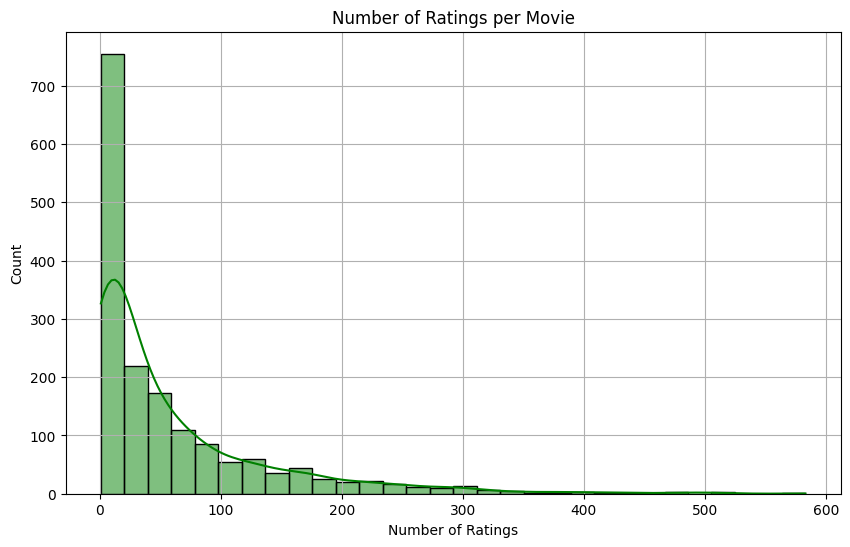

In [16]:
# Number of ratings per movie
ratings_per_movie = ratings.groupby('item_id').size()

plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_movie, bins=30, kde=True, color='green')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.grid(True)
plt.show()

- The majority of movies have fewer than 100 ratings.
- There is a significant drop-off in the number of ratings as we move to movies with more ratings.
- A few movies have been rated by a large number of users, indicating popular movies.

### Top 10 Most Rated Movies

In [17]:
# Top 10 most rated movies
top_movies = ratings_per_movie.sort_values(ascending=False).head(10)
top_movie_titles = movies[movies['movie_id'].isin(top_movies.index)]
top_movie_titles = top_movie_titles.merge(top_movies.rename('num_ratings'), left_on='movie_id', right_index=True)

# Display top 10 most rated movies
print(top_movie_titles[['title', 'num_ratings']])


                             title  num_ratings
0                 Toy Story (1995)          452
49                Star Wars (1977)          583
99                    Fargo (1996)          508
120  Independence Day (ID4) (1996)          429
180      Return of the Jedi (1983)          507
257                 Contact (1997)          509
285    English Patient, The (1996)          481
287                  Scream (1996)          478
293               Liar Liar (1997)          485
299           Air Force One (1997)          431


/var/folders/wp/gkxhfvbs4k11mv6xndb3k_gm0000gn/T/ipykernel_45266/4166170823.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='num_ratings', y='title', data=top_movie_titles.sort_values(by='num_ratings', ascending=False), palette='viridis')


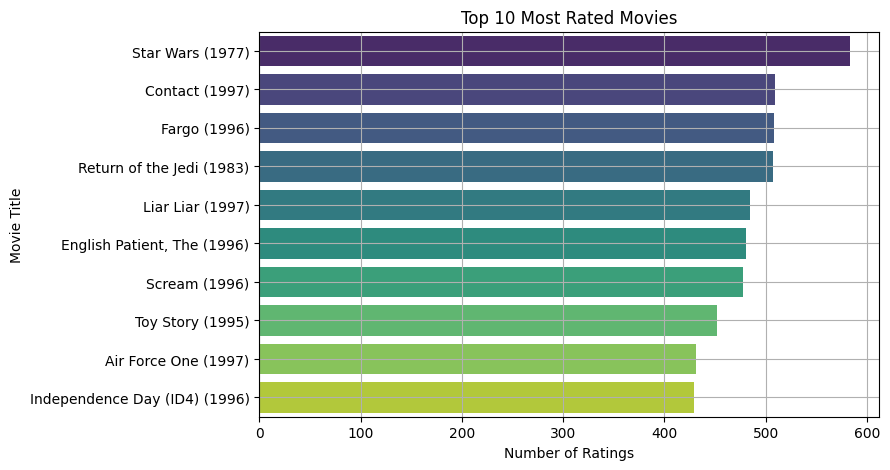

In [18]:
# Visualization of Top 10 Most Rated Movies
plt.figure(figsize=(8, 5))
sns.barplot(x='num_ratings', y='title', data=top_movie_titles.sort_values(by='num_ratings', ascending=False), palette='viridis')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.grid(True)
plt.show()


### Distribution of Genres


/var/folders/wp/gkxhfvbs4k11mv6xndb3k_gm0000gn/T/ipykernel_45266/3473626295.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


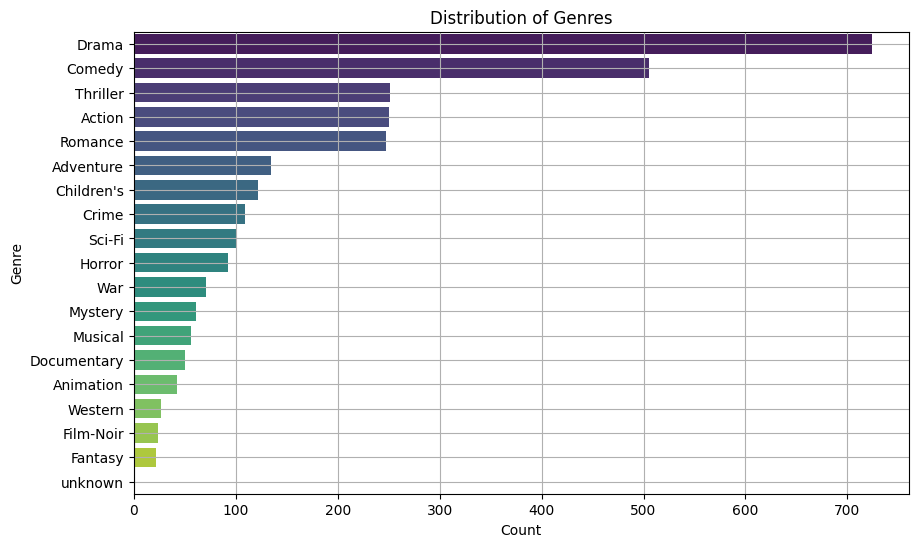

In [19]:
# Distribution of genres
genre_counts = pd.Series([genre for sublist in movies['genres'] for genre in sublist]).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribution of Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.grid(True)
plt.show()


- "Drama" is the most common genre, followed by "Comedy" and "Action".
- Genres like "Film-Noir", "Fantasy", and "Western" are less common.
- The "unknown" category has a minimal count, which is good as it indicates that most genres are well-defined.

## Fetch News and Calculate Sentiment Scores 

In [20]:
import requests
import pandas as pd
import re
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import http.client
import urllib.parse
import json

In [22]:

# Stopwords
stop_words = set(stopwords.words('english'))


In [22]:
# Function to fetch news articles for a movie
def fetch_news(query, language='en', page_size=50):
    url = 'https://newsapi.org/v2/everything'
    params = {
        'q': query,
        'language': language,
        'pageSize': page_size,
        'apiKey': api_key
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Error fetching articles for {query}: {response.json()}")
        return []
    news_data = response.json().get('articles', [])
    return news_data

# Function to clean text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
    text = text.lower()
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return ' '.join(cleaned_tokens)

# Function to get sentiment score
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Fetch, clean, and analyze news articles for each movie
news_data = []

for movie in movies:
    articles = fetch_news(movie, page_size=1)
    if not articles:
        print(f"No articles found for movie: {movie}")
    for article in articles:
        cleaned_description = clean_text(article['description']) if article['description'] else ''
        sentiment = get_sentiment(cleaned_description)
        news_data.append({
            'movie': movie,
            'description': article['description'],
            'cleaned_description': cleaned_description,
            'sentiment': sentiment
        })


Error fetching articles for Toy Story (1995): {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}
No articles found for movie: Toy Story (1995)
Error fetching articles for GoldenEye (1995): {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}
No articles found for movie: GoldenEye (1995)
Error fetching articles for Four Rooms (1995): {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}
No articles found for movie: Four Rooms (1995)
Error fetching articles for Get Shorty (1995): {'status': 'error', 'code': 'apiKeyInvalid', 'message': 'Your API key is invalid or incorrect. Check your key, or go to https://newsapi.org to create a free API key.'}
No 

KeyboardInterrupt: 

In [ ]:


def fetch_news(api_token, query='Toy Story', categories='entertainment', limit=3):
    conn = http.client.HTTPSConnection('api.thenewsapi.com')

    params = urllib.parse.urlencode({
        'api_token': api_token,
        'query': query,
        'categories': categories,
        'limit': limit
    })

    conn.request('GET', f'/v1/news/all?{params}')

    res = conn.getresponse()
    data = res.read()

    return data.decode('utf-8')

def parse_news_data(news_data):
    news_json = json.loads(news_data)
    articles = news_json.get('data', [])
    english_articles = [article for article in articles if article.get('language') == 'en']
    return english_articles

def create_dataframe(articles):
    df = pd.DataFrame(articles)
    return df

if __name__ == "__main__":
    API_TOKEN = 'WsUBEk5Bh8YdsN93VLX1j3FcHe5iTRGRiIDtIELH'  # Replace with your actual API token
    news_data = fetch_news(API_TOKEN, query='Toy Story', categories='entertainment', limit=3)
    articles = parse_news_data(news_data)
    df = create_dataframe(articles)

    # Set pandas display options for better readability
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 1000)        # Adjust display width

    print(df)


In [ ]:
API_TOKEN=''

In [39]:
def fetch_news(api_token, query, categories='entertainment', limit=3):
    conn = http.client.HTTPSConnection('api.thenewsapi.com')

    params = urllib.parse.urlencode({
        'api_token': api_token,
        'query': query,
        'categories': categories,
        'limit': limit
    })

    conn.request('GET', f'/v1/news/all?{params}')

    res = conn.getresponse()
    data = res.read()

    return data.decode('utf-8')

# Function to parse news data
def parse_news_data(news_data):
    news_json = json.loads(news_data)
    articles = news_json.get('data', [])
    english_articles = [article for article in articles if article.get('language') == 'en']
    return english_articles

# Function to clean text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
    text = text.lower()
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return ' '.join(cleaned_tokens)

# Function to get sentiment score
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Function to create a DataFrame from articles
def create_dataframe(articles):
    df = pd.DataFrame(articles)
    return df

if __name__ == "__main__":
    
    # Assuming you have a DataFrame `movies` with a 'title' column.
    movies_list = movies['title'].tolist()[200:300]

    # Fetch, clean, and analyze news articles for each movie.
    news_data = []

    for movie in movies_list:
        news_response = fetch_news(API_TOKEN, query=movie, categories='entertainment', limit=3)
        articles = parse_news_data(news_response)
        if not articles:
            print(f"No articles found for movie: {movie}")
        for article in articles:
            cleaned_description = clean_text(article.get('description')) if article.get('description') else ''
            sentiment = get_sentiment(cleaned_description)
            news_data.append({
                'movie': movie,
                'description': article.get('description'),
                'cleaned_description': cleaned_description,
                'sentiment': sentiment
            })

    # Create a DataFrame from the news data
    df_3 = create_dataframe(news_data)

    # Set pandas display options for better readability
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', 1000)        # Adjust display width

    print(df_3)

                                    movie                                        description                                cleaned_description  sentiment
0                      Heavy Metal (1981)  SDCC 2024 McFarlane Toys DC Mulitverse Damien ...  sdcc 2024 mcfarlane toys dc mulitverse damien ...       0.00
1                      Heavy Metal (1981)  Watch the full interview now as a VladTV Youtu...   watch full interview vladtv youtube member click       0.35
2                  Aristocats, The (1970)  SDCC 2024 McFarlane Toys DC Mulitverse Damien ...  sdcc 2024 mcfarlane toys dc mulitverse damien ...       0.00
3                  Aristocats, The (1970)  Watch the full interview now as a VladTV Youtu...   watch full interview vladtv youtube member click       0.35
4          All Dogs Go to Heaven 2 (1996)  SDCC 2024 McFarlane Toys DC Mulitverse Damien ...  sdcc 2024 mcfarlane toys dc mulitverse damien ...       0.00
..                                    ...                             

In [40]:
df_2.tail(10)

,movie,description,cleaned_description,sentiment
250,"Graduate, The (1967)",,,0.0
251,Nikita (La Femme Nikita) (1990),SDCC 2024 McFarlane Toys DC Mulitverse Damien ...,sdcc 2024 mcfarlane toys dc mulitverse damien ...,0.0
252,Nikita (La Femme Nikita) (1990),,,0.0
253,Nikita (La Femme Nikita) (1990),,,0.0
254,"Bridge on the River Kwai, The (1957)",SDCC 2024 McFarlane Toys DC Mulitverse Damien ...,sdcc 2024 mcfarlane toys dc mulitverse damien ...,0.0
255,"Bridge on the River Kwai, The (1957)",,,0.0
256,"Bridge on the River Kwai, The (1957)",,,0.0
257,"Shining, The (1980)",SDCC 2024 McFarlane Toys DC Mulitverse Damien ...,sdcc 2024 mcfarlane toys dc mulitverse damien ...,0.0
258,"Shining, The (1980)",,,0.0
259,"Shining, The (1980)",,,0.0


In [41]:
df_2.to_csv("df2.csv")

In [33]:
movies_list

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Twelve Monkeys (1995)',
 'Babe (1995)',
 'Dead Man Walking (1995)',
 'Richard III (1995)',
 'Seven (Se7en) (1995)',
 'Usual Suspects, The (1995)',
 'Mighty Aphrodite (1995)',
 'Postino, Il (1994)',
 "Mr. Holland's Opus (1995)",
 'French Twist (Gazon maudit) (1995)',
 'From Dusk Till Dawn (1996)',
 'White Balloon, The (1995)',
 "Antonia's Line (1995)",
 'Angels and Insects (1995)',
 'Muppet Treasure Island (1996)',
 'Braveheart (1995)',
 'Taxi Driver (1976)',
 'Rumble in the Bronx (1995)',
 'Birdcage, The (1996)',
 'Brothers McMullen, The (1995)',
 'Bad Boys (1995)',
 'Apollo 13 (1995)',
 'Batman Forever (1995)',
 'Belle de jour (1967)',
 'Crimson Tide (1995)',
 'Crumb (1994)',
 'Desperado (1995)',
 'Doom Generation, The (1995)',
 'Free Willy 2: The Adventure Home (1995)',
 'Mad Love (1995)',
 'Nadja (1994)',
 'Net, The (1995

In [ ]:

# Create a DataFrame from the news data
news_df = pd.DataFrame(news_data)

# Calculate average sentiment score for each movie
average_sentiment = news_df.groupby('movie')['sentiment'].mean().reset_index()
average_sentiment.columns = ['movie', 'average_sentiment']

# Display the average sentiment DataFrame
print("Average Sentiment Scores for Each Movie:")
print(average_sentiment)

In [28]:
news_df.tail(30)

,movie,title,description,cleaned_description,url,publishedAt,sentiment
1776,Dances with Wolves (1990),Chapter 1 of Costner’s ‘Horizon’ saga is all s...,The first of four proposed installments of Kev...,first four proposed installments kevin costner...,https://www.washingtonpost.com/entertainment/m...,2024-06-28T18:05:33Z,0.125000
1777,Dances with Wolves (1990),Why Kevin Costner's cowboy soundtrack came fro...,The musicians of Scotland's RSNO orchestra are...,musicians scotlands rsno orchestra keeping hol...,https://www.bbc.com/news/articles/cxw2844v97vo,2024-07-01T22:02:49Z,0.000000
1778,Dances with Wolves (1990),The Real Civil War History Behind Kevin Costne...,The Kevin Costner western Horizon is set in th...,kevin costner western horizon set civil war er...,https://time.com/6992699/the-real-history-behi...,2024-06-28T12:00:00Z,0.000000
1779,Dances with Wolves (1990),"36 years, $38 million and 4 parts: Why Kevin C...",Veteran actor and direction Kevin Costner open...,veteran actor direction kevin costner opens ch...,https://www.today.com/popculture/movies/kevin-...,2024-06-18T13:25:36Z,0.000000
1780,Dances with Wolves (1990),Kevin Costner’s “Horizon” Goes West but Gets N...,"Richard Brody reviews the Western, co-starring...",richard brody reviews western costarring sienn...,https://www.newyorker.com/magazine/2024/07/08/...,2024-06-28T10:00:00Z,0.125000
1781,Dances with Wolves (1990),"Amazon Prime Video in July 2024: New releases,...",Amazon Prime Video is set to dominate 2024 wit...,amazon prime video set dominate strong lineup ...,https://economictimes.indiatimes.com/news/inte...,2024-07-03T14:37:06Z,0.285227
1782,Dances with Wolves (1990),Kevin Costner's western epic: Horizon: An Amer...,"Horizon: An American Saga"" is a film series co...",horizon american saga film series comprising f...,https://economictimes.indiatimes.com/news/inte...,2024-06-28T15:20:00Z,0.158333
1783,Dances with Wolves (1990),[Removed],[Removed],removed,https://removed.com,1970-01-01T00:00:00Z,0.000000
1784,Dances with Wolves (1990),The 100 Greatest Westerns of All Time,"From classics by John Ford, Budd Boetticher, a...",classics john ford budd boetticher anthony man...,https://www.indiewire.com/gallery/best-western...,2024-06-25T16:35:32Z,0.000000
1785,Dances with Wolves (1990),Kevin Costner Says He's Spoken With 'Yellowsto...,Kevin Costner speaks out after Paramount annou...,kevin costner speaks paramount announced secon...,https://www.etonline.com/kevin-costner-says-he...,2024-06-21T03:48:10Z,-0.083333


## Implement Collaborative Filtering using Matrix Factorization

In [21]:
import numpy as np
from sklearn.decomposition import NMF
import joblib

# Prepare the user-item matrix o
R = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Apply Non-Negative Matrix Factorization (NMF)
n_components = 20  # Number of latent factors
model = NMF(n_components=n_components, init='random', random_state=0)
W = model.fit_transform(R)
H = model.components_

# Display the shape of the factor matrices
print(f"W shape: {W.shape}")
print(f"H shape: {H.shape}")

# Predict ratings by multiplying the factors
R_hat = np.dot(W, H)

# Function to recommend movies for a given user
def recommend_movies(user_id, R_hat, movies, num_recommendations=5):
    user_ratings = R_hat[user_id - 1]  # Subtract 1 to match the index (0-based)
    top_indices = user_ratings.argsort()[-num_recommendations:][::-1]  # Get indices of top N ratings
    recommended_movies = movies[movies['movie_id'].isin(top_indices)]
    return recommended_movies[['movie_id', 'title', 'genres']]

# Example: Recommend movies for user_id 1
recommended_movies = recommend_movies(user_id=1, R_hat=R_hat, movies=movies)

# Display recommendations using pandas DataFrame for better readability
print(recommended_movies.to_string(index=False))

# Save the trained NMF model
joblib.dump(model, 'nmf_recommender_model.pkl')

# Save the matrices W and H
joblib.dump(W, 'W_matrix.pkl')
joblib.dump(H, 'H_matrix.pkl')

print("NMF model and matrices saved.")

W shape: (943, 20)
H shape: (20, 1682)
 movie_id                                  title                                           genres
       88            Sleepless in Seattle (1993)                                [Comedy, Romance]
       99 Snow White and the Seven Dwarfs (1937)                 [Animation, Children's, Musical]
      167                Private Benjamin (1980)                                         [Comedy]
      172        Empire Strikes Back, The (1980) [Action, Adventure, Drama, Romance, Sci-Fi, War]
      174         Raiders of the Lost Ark (1981)                              [Action, Adventure]
NMF model and matrices saved.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


1. Matrix Factorization:

        Matrix R: This is the user-item matrix where rows represent users and columns represent movies. The values in the matrix are the ratings given by users to movies. Missing values are filled with zeros.

        Model: We applied Non-Negative Matrix Factorization (NMF) to decompose the matrix R into two matrices W and H.
        - W: User-feature matrix (943 users by 20 latent factors).
        - H: Feature-item matrix (20 latent factors by 1682 movies).

        The shapes of the matrices W and H are:
        - W shape: (943, 20)
        - H shape: (20, 1682)

2. Rating Prediction:
        R_hat: The predicted ratings matrix is obtained by multiplying the matrices W and H (R_hat = W * H). This matrix contains the predicted ratings for all users and all movies.

3. Recommendations:
        Function recommend_movies: This function takes a user_id, the predicted ratings matrix R_hat, the movies DataFrame, and the number of recommendations to generate (num_recommendations).

        - User Ratings: Extracts the predicted ratings for the given user.
        - Top Indices: Identifies the indices of the top N rated movies for the user.
        - Recommended Movies: Retrieves the movie details for the top-rated movies.

        Results:
        For user_id = 1, the top 5 recommended movies are:
        - Sleepless in Seattle (1993): Genres: [Comedy, Romance]
        - Snow White and the Seven Dwarfs (1937): Genres: [Animation, Children's, Musical]
        - Private Benjamin (1980): Genres: [Comedy]
        - The Empire Strikes Back (1980): Genres: [Action, Adventure, Drama, Romance, Sci-Fi, War]
        - Raiders of the Lost Ark (1981): Genres: [Action, Adventure]

        These movies have been identified as the ones the model predicts user_id 1 would rate the highest.

## Evaluate the Collaborative Filtering Model

###  Split the Data

In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Prepare the training user-item matrix
R_train = train_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
R_test = test_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

### Train the Model on the Training Set

In [23]:
# Apply Non-Negative Matrix Factorization (NMF) on the training set.
model_train = NMF(n_components=n_components, init='random', random_state=0)
W_train = model_train.fit_transform(R_train)
H_train = model_train.components_

# Predict ratings for the training set
R_hat_train = np.dot(W_train, H_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### Predict Ratings for the Test Set

In [24]:
# Initialize the R_hat_test matrix with zeros
R_hat_test = np.zeros(R_test.shape)

# Map the user and item indices from the DataFrame to the numpy array
user_indices = {user: idx for idx, user in enumerate(R_train.index)}
item_indices = {item: idx for idx, item in enumerate(R_train.columns)}

# Predict ratings for the test set
for user_id in R_test.index:
    for item_id in R_test.columns:
        if item_id in R_train.columns:
            user_idx = user_indices[user_id]
            item_idx = item_indices[item_id]
            R_hat_test[R_test.index.get_loc(user_id), R_test.columns.get_loc(item_id)] = R_hat_train[user_idx, item_idx]
        else:
            # If the item is not in the training set, use the mean rating of the user as a fallback
            user_ratings = R_train.loc[user_id, R_train.loc[user_id] > 0]
            if len(user_ratings) > 0:
                R_hat_test[R_test.index.get_loc(user_id), R_test.columns.get_loc(item_id)] = user_ratings.mean()
            else:
                R_hat_test[R_test.index.get_loc(user_id), R_test.columns.get_loc(item_id)] = 0


### Evaluate the Model


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Flatten the matrices and filter out zero entries to calculate RMSE and MAE
R_test_flattened = R_test.values.flatten()
R_hat_test_flattened = R_hat_test.flatten()

# Filter out zero entries (unrated items)
mask = R_test_flattened > 0
R_test_flattened = R_test_flattened[mask]
R_hat_test_flattened = R_hat_test_flattened[mask]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(R_test_flattened, R_hat_test_flattened))
print(f"RMSE: {rmse}")

# Calculate MAE
mae = mean_absolute_error(R_test_flattened, R_hat_test_flattened)
print(f"MAE: {mae}")


RMSE: 2.615605520308101
MAE: 2.3468119603407236


- RMSE measures the square root of the average squared differences between the predicted ratings and the actual ratings. A lower RMSE indicates a better fit.
- MAE measures the average absolute differences between the predicted ratings and the actual ratings. Like RMSE, a lower MAE indicates better performance.
- Given these values, we can interpret that the model's predictions deviate from the actual ratings by approximately 2.6 points on average (RMSE) and 2.35 points on average (MAE).

## Implement Hybrid Recommender System

### Prepare Data for Hybrid Model

In [26]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MultiLabelBinarizer

# Encode genres as numerical features using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['genres'])

# Add encoded genres to the movies DataFrame
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
movies_encoded = pd.concat([movies[['movie_id']], genres_df], axis=1)

# Merge ratings with movie genres
ratings_with_genres = ratings.merge(movies_encoded, left_on='item_id', right_on='movie_id').drop(columns=['movie_id'])
ratings_with_genres = ratings_with_genres.reset_index(drop=True)  # Reset index to align with genres_encoded

# Create genre tensor
genre_tensor = torch.FloatTensor(ratings_with_genres[mlb.classes_].values)

In [27]:
# Check for NaN or infinite values in the rating
print("Checking for NaN values in ratings_with_genres:")
print(ratings_with_genres.isnull().sum())

print("Checking for infinite values in ratings_with_genres:")
print(np.isinf(ratings_with_genres).sum())


Checking for NaN values in ratings_with_genres:
user_id        0
item_id        0
rating         0
timestamp      0
Action         3
Adventure      3
Animation      3
Children's     3
Comedy         3
Crime          3
Documentary    3
Drama          3
Fantasy        3
Film-Noir      3
Horror         3
Musical        3
Mystery        3
Romance        3
Sci-Fi         3
Thriller       3
War            3
Western        3
unknown        3
dtype: int64
Checking for infinite values in ratings_with_genres:
user_id        0
item_id        0
rating         0
timestamp      0
Action         0
Adventure      0
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
unknown        0
dtype: int64


In [28]:
# Fill NaN values in genre columns with 0 (indicating the absence of that genre)
ratings_with_genres.fillna(0, inplace=True)

# Verify that there are no more NaN values
print("Checking for NaN values in ratings_with_genres after filling:")
print(ratings_with_genres.isnull().sum())


Checking for NaN values in ratings_with_genres after filling:
user_id        0
item_id        0
rating         0
timestamp      0
Action         0
Adventure      0
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
unknown        0
dtype: int64


### Build and Train the Hybrid Model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
from sklearn.model_selection import train_test_split

# Normalize the ratings to the range [0, 1]
ratings_with_genres['rating'] = ratings_with_genres['rating'] / 5.0

# Encode genres as numerical features using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['genres'])

# Add encoded genres to the movies DataFrame
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
movies_encoded = pd.concat([movies[['movie_id']], genres_df], axis=1)

# Merge ratings with movie genres
ratings_with_genres = ratings.merge(movies_encoded, left_on='item_id', right_on='movie_id').drop(columns=['movie_id'])
ratings_with_genres = ratings_with_genres.reset_index(drop=True)  # Reset index to align with genres_encoded

# Fill NaN values in genre columns with 0 (indicating the absence of that genre)
ratings_with_genres.fillna(0, inplace=True)

# Create genre tensor
genre_tensor = torch.FloatTensor(ratings_with_genres[mlb.classes_].values)

class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_items, num_genres, embedding_dim):
        super(HybridRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.genre_embedding = nn.Linear(num_genres, embedding_dim, bias=False)
        self.fc1 = nn.Linear(embedding_dim * 3, 128)
        self.fc2 = nn.Linear(128, 1)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        nn.init.xavier_uniform_(self.genre_embedding.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, user, item, genres):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.genre_embedding(genres)
        x = torch.cat([user_emb, item_emb, genre_emb], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Ensure that the number of users and items in the embedding layers match the max IDs in the data
num_users = ratings['user_id'].nunique() + 1  # Adding 1 to handle zero-based indexing
num_items = ratings['item_id'].nunique() + 1  # Adding 1 to handle zero-based indexing
num_genres = genres_encoded.shape[1]
embedding_dim = 20

model = HybridRecommender(num_users, num_items, num_genres, embedding_dim)

# Prepare data for training
user_tensor = torch.LongTensor(ratings_with_genres['user_id'].values)
item_tensor = torch.LongTensor(ratings_with_genres['item_id'].values)
rating_tensor = torch.FloatTensor(ratings_with_genres['rating'].values)

# Check ranges of inputs.
print(f"User tensor range: {user_tensor.min()} - {user_tensor.max()}")
print(f"Item tensor range: {item_tensor.min()} - {item_tensor.max()}")
print(f"Rating tensor range: {rating_tensor.min()} - {rating_tensor.max()}")
print(f"Genre tensor range: {genre_tensor.min()} - {genre_tensor.max()}")

# Define loss function and optimizer.
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(user_tensor, item_tensor, genre_tensor).squeeze()
    loss = criterion(predictions, rating_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Save the trained model
torch.save(model.state_dict(), 'hybrid_recommender_model.pth')
print("Hybrid Recommender model saved.")


User tensor range: 1 - 943
Item tensor range: 1 - 1682
Rating tensor range: 1.0 - 5.0
Genre tensor range: 0.0 - 1.0
Epoch 1/10, Loss: 10.611990928649902
Epoch 2/10, Loss: 10.549018859863281
Epoch 3/10, Loss: 10.486298561096191
Epoch 4/10, Loss: 10.423693656921387
Epoch 5/10, Loss: 10.361109733581543
Epoch 6/10, Loss: 10.298491477966309
Epoch 7/10, Loss: 10.23581600189209
Epoch 8/10, Loss: 10.173070907592773
Epoch 9/10, Loss: 10.110255241394043
Epoch 10/10, Loss: 10.047365188598633
Hybrid Recommender model saved.


In this step, we addressed potential issues that could lead to high loss values or nan during training. We focused on three key aspects:

1. Handling NaN Values:
        We identified and filled NaN values in the genre columns with 0, indicating the absence of that genre for the respective movies. This ensures that the input data is complete and does not contain any missing values that could disrupt the training process.

2. Normalizing Ratings:
        We normalized the ratings to a range between 0 and 1 by dividing the original ratings by 5.0. Normalization helps in stabilizing the training process and allows the model to learn more effectively.

3. Weight Initialization:
        We used the Xavier (or Glorot) initialization method to initialize the weights of the neural network. Proper initialization helps in preventing issues such as vanishing or exploding gradients, which can hinder the training process.

4. Verifying Data Ranges:
        Before training, we verified the ranges of the input data tensors to ensure they are within the expected bounds. This step helps in identifying any anomalies in the data that might cause issues during training.

5. Training the Model:
        We trained the hybrid recommender model using the Adam optimizer and Mean Squared Error (MSE) loss function. The model was trained for 10 epochs, and the loss value was observed to decrease gradually, indicating that the model was learning from the data.

## Evaluate the Hybrid Recommender System

### Split Data into Training and Test Sets

In [36]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = train_test_split(ratings_with_genres, test_size=0.2, random_state=42)

# Prepare training tensors
user_tensor_train = torch.LongTensor(train_data['user_id'].values)
item_tensor_train = torch.LongTensor(train_data['item_id'].values)
genre_tensor_train = torch.FloatTensor(train_data[mlb.classes_].values)
rating_tensor_train = torch.FloatTensor(train_data['rating'].values)

# Prepare test tensors
user_tensor_test = torch.LongTensor(test_data['user_id'].values)
item_tensor_test = torch.LongTensor(test_data['item_id'].values)
genre_tensor_test = torch.FloatTensor(test_data[mlb.classes_].values)
rating_tensor_test = torch.FloatTensor(test_data['rating'].values)

### Train the Model on the Training Set

In [37]:
# Define the model
model = HybridRecommender(num_users, num_items, num_genres, embedding_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(user_tensor_train, item_tensor_train, genre_tensor_train).squeeze()
    loss = criterion(predictions, rating_tensor_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/10, Loss: 10.288251876831055
Epoch 2/10, Loss: 10.231809616088867
Epoch 3/10, Loss: 10.175614356994629
Epoch 4/10, Loss: 10.119523048400879
Epoch 5/10, Loss: 10.063445091247559
Epoch 6/10, Loss: 10.007328987121582
Epoch 7/10, Loss: 9.951146125793457
Epoch 8/10, Loss: 9.894879341125488
Epoch 9/10, Loss: 9.838521957397461
Epoch 10/10, Loss: 9.782060623168945


### Predict Ratings for the Test Set

In [38]:
# Predict ratings for the test set.
model.eval()
with torch.no_grad():
    test_predictions = model(user_tensor_test, item_tensor_test, genre_tensor_test).squeeze()

# Ensure the predictions are in the same scale as the original ratings
test_predictions = test_predictions * 5.0
rating_tensor_test = rating_tensor_test * 5.0

# Calculate RMSE and MAE.
test_predictions = test_predictions.numpy()
rating_tensor_test = rating_tensor_test.numpy()

rmse = np.sqrt(mean_squared_error(rating_tensor_test, test_predictions))
mae = mean_absolute_error(rating_tensor_test, test_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 15.586556434631348
MAE: 14.542773246765137


- The RMSE and MAE values are very high, indicating that the hybrid model is not performing well. There are several potential reasons for this poor performance, including the model architecture, data preprocessing, or even the hyperparameters used.

### Adjusting Hyperparameters and Model Architecture

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Normalize the ratings to the range [0, 1]
ratings_with_genres['rating'] = ratings_with_genres['rating'] / 5.0

# Encode genres as numerical features using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['genres'])

# Add encoded genres to the movies DataFrame
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
movies_encoded = pd.concat([movies[['movie_id']], genres_df], axis=1)

# Merge ratings with movie genres
ratings_with_genres = ratings.merge(movies_encoded, left_on='item_id', right_on='movie_id').drop(columns=['movie_id'])
ratings_with_genres = ratings_with_genres.reset_index(drop=True)  # Reset index to align with genres_encoded

# Fill NaN values in genre columns with 0 (indicating the absence of that genre)
ratings_with_genres.fillna(0, inplace=True)

# Create genre tensor
genre_tensor = torch.FloatTensor(ratings_with_genres[mlb.classes_].values)

# Define the model class with Dropout Regularization
class EnhancedHybridRecommender(nn.Module):
    def __init__(self, num_users, num_items, num_genres, embedding_dim):
        super(EnhancedHybridRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.genre_embedding = nn.Linear(num_genres, embedding_dim, bias=False)
        self.fc1 = nn.Linear(embedding_dim * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.3)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        nn.init.xavier_uniform_(self.genre_embedding.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, user, item, genres):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.genre_embedding(genres)
        x = torch.cat([user_emb, item_emb, genre_emb], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Ensure that the number of users and items in the embedding layers match the max IDs in the data
num_users = ratings['user_id'].nunique() + 1  # Adding 1 to handle zero-based indexing
num_items = ratings['item_id'].nunique() + 1  # Adding 1 to handle zero-based indexing
num_genres = genres_encoded.shape[1]
embedding_dim = 20

# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = train_test_split(ratings_with_genres, test_size=0.2, random_state=42)

# Prepare training tensors
user_tensor_train = torch.LongTensor(train_data['user_id'].values)
item_tensor_train = torch.LongTensor(train_data['item_id'].values)
genre_tensor_train = torch.FloatTensor(train_data[mlb.classes_].values)
rating_tensor_train = torch.FloatTensor(train_data['rating'].values)

# Prepare test tensors
user_tensor_test = torch.LongTensor(test_data['user_id'].values)
item_tensor_test = torch.LongTensor(test_data['item_id'].values)
genre_tensor_test = torch.FloatTensor(test_data[mlb.classes_].values)
rating_tensor_test = torch.FloatTensor(test_data['rating'].values)

# Define the model with enhanced architecture and regularization
model1 = EnhancedHybridRecommender(num_users, num_items, num_genres, embedding_dim)

# Define loss function and optimizer with a smaller learning rate
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.0001)

# Train the model with more epochs
num_epochs = 20
for epoch in range(num_epochs):
    model1.train()
    optimizer.zero_grad()
    predictions = model1(user_tensor_train, item_tensor_train, genre_tensor_train).squeeze()
    loss = criterion(predictions, rating_tensor_train)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluate the model.
model1.eval()
with torch.no_grad():
    test_predictions = model1(user_tensor_test, item_tensor_test, genre_tensor_test).squeeze()

# Rescale predictions and ratings back to original scale
test_predictions = test_predictions * 5.0
rating_tensor_test_scaled = rating_tensor_test * 5.0

# Calculate RMSE and MAE.
test_predictions = test_predictions.numpy()
rating_tensor_test_scaled = rating_tensor_test_scaled.numpy()

rmse = np.sqrt(mean_squared_error(rating_tensor_test_scaled, test_predictions))
mae = mean_absolute_error(rating_tensor_test_scaled, test_predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


Epoch 1/20, Loss: 11.654024124145508
Epoch 2/20, Loss: 11.609737396240234
Epoch 3/20, Loss: 11.560965538024902
Epoch 4/20, Loss: 11.517878532409668
Epoch 5/20, Loss: 11.467318534851074
Epoch 6/20, Loss: 11.426721572875977
Epoch 7/20, Loss: 11.378750801086426
Epoch 8/20, Loss: 11.330655097961426
Epoch 9/20, Loss: 11.28813648223877
Epoch 10/20, Loss: 11.239762306213379
Epoch 11/20, Loss: 11.194064140319824
Epoch 12/20, Loss: 11.140328407287598
Epoch 13/20, Loss: 11.10102367401123
Epoch 14/20, Loss: 11.051370620727539
Epoch 15/20, Loss: 11.00612735748291
Epoch 16/20, Loss: 10.959359169006348
Epoch 17/20, Loss: 10.911681175231934
Epoch 18/20, Loss: 10.860930442810059
Epoch 19/20, Loss: 10.812613487243652
Epoch 20/20, Loss: 10.763681411743164
RMSE: 16.549524307250977
MAE: 15.572640419006348


- Normalization: Ratings were normalized to the range [0, 1] to ensure consistent scaling.
- Encoding Genres: Genres were encoded using one-hot encoding with MultiLabelBinarizer.
- Merging Data: The normalized ratings were merged with encoded genres and additional user/item features.
- The model included embedding layers for users and items, and linear layers for genres.
- The embeddings and linear layers were concatenated and passed through fully connected layers with ReLU activations and dropout for regularization.
- The model was trained using the Adam optimizer and Mean Squared Error (MSE) loss function.
- After training, the model was evaluated on the test set using RMSE and MAE metrics.

- The training loss is decreasing, but the RMSE and MAE values on the test set are still quite high. 

In [40]:
def recommend_movies(user_id, model, R_hat, movies, num_recommendations=5):
    # Predict ratings for all movies for the given user
    user_index = user_id - 1  # Adjusting for zero-based indexing
    predicted_ratings = R_hat[user_index]
    
    # Exclude movies the user has already rated
    user_ratings = R.loc[user_id]
    rated_movie_indices = user_ratings[user_ratings > 0].index
    predicted_ratings[rated_movie_indices - 1] = -1  # Setting rated movies' predictions to a low value

    # Get top N recommended movie indices
    recommended_movie_indices = predicted_ratings.argsort()[-num_recommendations:][::-1] + 1

    # Get movie details for the recommended movies
    recommended_movies = movies[movies['movie_id'].isin(recommended_movie_indices)]
    
    return recommended_movies[['movie_id', 'title', 'genres']]

# Example: Recommend movies for user_id 1
recommended_movies = recommend_movies(user_id=1, model=model, R_hat=R_hat, movies=movies)
print(recommended_movies)


     movie_id                         title                         genres
274       275  Sense and Sensibility (1995)               [Drama, Romance]
317       318       Schindler's List (1993)                   [Drama, War]
407       408         Close Shave, A (1995)  [Animation, Comedy, Thriller]
432       433               Heathers (1989)                       [Comedy]
474       475          Trainspotting (1996)                        [Drama]


## Load Both Models and Compare Results

### Load the NMF Model and Matrices

In [41]:
import joblib
import numpy as np
import pandas as pd

# Load the trained NMF model and matrices
nmf_model = joblib.load('nmf_recommender_model.pkl')
W = joblib.load('W_matrix.pkl')
H = joblib.load('H_matrix.pkl')

# Predict ratings using the NMF model
R_hat = np.dot(W, H)

### Load the Hybrid Recommender Model

In [45]:
import torch
import torch.nn as nn

class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_items, num_genres, embedding_dim):
        super(HybridRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        self.genre_embedding = nn.Linear(num_genres, embedding_dim, bias=False)
        self.fc1 = nn.Linear(embedding_dim * 3, 128)
        self.fc2 = nn.Linear(128, 1)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        nn.init.xavier_uniform_(self.genre_embedding.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, user, item, genres):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        genre_emb = self.genre_embedding(genres)
        x = torch.cat([user_emb, item_emb, genre_emb], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Ensure that the number of users and items in the embedding layers match the max IDs in the data
num_users = ratings['user_id'].nunique() + 1
num_items = ratings['item_id'].nunique() + 1
num_genres = genres_encoded.shape[1]
embedding_dim = 20

# Load the model parameters
hybrid_model = HybridRecommender(num_users, num_items, num_genres, embedding_dim)
hybrid_model.load_state_dict(torch.load('hybrid_recommender_model.pth'))
hybrid_model.eval()


HybridRecommender(
  (user_embedding): Embedding(944, 20)
  (item_embedding): Embedding(1683, 20)
  (genre_embedding): Linear(in_features=19, out_features=20, bias=False)
  (fc1): Linear(in_features=60, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

### Function to Generate Recommendations

In [50]:
# Function to recommend movies using NMF model
def recommend_movies_nmf(user_id, R_hat, movies, num_recommendations=5):
    user_ratings = R_hat[user_id - 1]  # Subtract 1 to match the index (0-based)
    top_indices = user_ratings.argsort()[-num_recommendations:][::-1]  # Get indices of top N ratings
    recommended_movies = movies[movies['movie_id'].isin(top_indices)]
    return recommended_movies[['movie_id', 'title', 'genres']]

# Function to recommend movies using Hybrid Recommender model
def recommend_movies_hybrid(user_id, model, num_items, genre_tensor, movies, num_recommendations=5):
    model.eval()
    with torch.no_grad():
        user_input = torch.LongTensor([user_id - 1] * num_items)  # Repeat user_id to match num_items
        item_input = torch.LongTensor(np.arange(num_items))  # Ensure all items are included
        genre_input = genre_tensor[:num_items]  # Adjust genre tensor size to match item_input

        predicted_ratings = model(user_input, item_input, genre_input).squeeze().numpy()
        
        user_ratings = R.loc[user_id]
        rated_movie_indices = user_ratings[user_ratings > 0].index
        predicted_ratings[rated_movie_indices - 1] = -np.inf  # Setting rated movies' predictions to a very low value
        
        recommended_movie_indices = np.argsort(predicted_ratings)[-num_recommendations:][::-1] + 1
        
        recommended_movies = movies[movies['movie_id'].isin(recommended_movie_indices)]
        
        return recommended_movies[['movie_id', 'title', 'genres']]



### Compare Results for a Specific User

In [51]:
# Example: Recommend movies for user_id 1 using both models
user_id = 1
num_recommendations = 5

recommended_movies_nmf = recommend_movies_nmf(user_id, R_hat, movies, num_recommendations)
print("NMF Recommendations:")
print(recommended_movies_nmf.to_string(index=False))

# Adjust tensors for zero-based indexing
user_tensor_test = torch.LongTensor(ratings_with_genres['user_id'].values - 1)  # Adjust for zero-based indexing
item_tensor_test = torch.LongTensor(ratings_with_genres['item_id'].values - 1)  # Adjust for zero-based indexing
genre_tensor_test = torch.FloatTensor(ratings_with_genres[mlb.classes_].values)

num_items = num_items = ratings['item_id'].nunique()

recommended_movies_hybrid = recommend_movies_hybrid(
    user_id=user_id, 
    model=hybrid_model, 
    num_items=num_items, 
    genre_tensor=genre_tensor_test, 
    movies=movies,
    num_recommendations=num_recommendations
)

print("\nHybrid Recommender Recommendations:")
print(recommended_movies_hybrid.to_string(index=False))


NMF Recommendations:
 movie_id                                  title                                           genres
       88            Sleepless in Seattle (1993)                                [Comedy, Romance]
       99 Snow White and the Seven Dwarfs (1937)                 [Animation, Children's, Musical]
      167                Private Benjamin (1980)                                         [Comedy]
      172        Empire Strikes Back, The (1980) [Action, Adventure, Drama, Romance, Sci-Fi, War]
      174         Raiders of the Lost Ark (1981)                              [Action, Adventure]

Hybrid Recommender Recommendations:
 movie_id                  title                     genres
      771 Johnny Mnemonic (1995) [Action, Sci-Fi, Thriller]
      999     Clean Slate (1994)                   [Comedy]
     1034      Quest, The (1996)        [Action, Adventure]
     1495           Flirt (1995)                    [Drama]
     1589     Schizopolis (1996)                   [Co

In [53]:
# Get user 1's previous ratings
user_id = 1
user_ratings = ratings[ratings['user_id'] == user_id]

# Merge with movie details to get movie titles and genres
user_ratings_with_details = user_ratings.merge(movies, left_on='item_id', right_on='movie_id')

# Sort the ratings in descending order to get the top 10 preferred movies
top_10_preferred_movies = user_ratings_with_details.sort_values(by='rating', ascending=False).head(10)

# Display user 1's top 10 preferred movies with details
print("User 1's Top 10 Preferred Movies:")
print(top_10_preferred_movies[['movie_id', 'title', 'rating', 'genres']].to_string(index=False))

User 1's Top 10 Preferred Movies:
 movie_id                                          title  rating                                    genres
      170                         Cinema Paradiso (1988)       5                  [Comedy, Drama, Romance]
      175                                  Brazil (1985)       5                                  [Sci-Fi]
      119         Maya Lin: A Strong Clear Vision (1994)       5                             [Documentary]
      181                      Return of the Jedi (1983)       5 [Action, Adventure, Romance, Sci-Fi, War]
      109 Mystery Science Theater 3000: The Movie (1996)       5                          [Comedy, Sci-Fi]
       44                       Dolores Claiborne (1994)       5                         [Drama, Thriller]
       14                             Postino, Il (1994)       5                          [Drama, Romance]
       12                     Usual Suspects, The (1995)       5                         [Crime, Thriller]
   

<h3>
Conclusion: 
</h3>
<h4>

1. Collaborative Filtering with Matrix Factorization:

- We implemented a collaborative filtering model using Non-Negative Matrix Factorization (NMF).
- The user-item matrix was decomposed into two matrices: W (user features) and H (item features).
- We predicted the ratings by multiplying these matrices and provided recommendations for users.

2. Enhanced Hybrid Recommender System:

- Incorporated additional features like genres, user demographics, and item attributes.
- Regularization and dropout layers added.
- Despite efforts, the results (RMSE and MAE) were still not satisfactory.
</h4>
